# Subspace EKF

In [2]:
import jax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Callable
from flax.training.train_state import TrainState
from jax.flatten_util import ravel_pytree
from rebayes.sgd_filter import sgd
from rebayes.low_rank_filter import subspace_filter
from functools import partial

/home/gerardoduran/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-12 10:56:18.446324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
import tensorflow_datasets as tfds

def process_dataset(Xtr, Ytr, Xval, Yval, Xte, Yte, shuffle=False, oh_train=True, key=0):
    if isinstance(key, int):
        key = jax.random.PRNGKey(key)
        
    # Reshape data
    Xtr = Xtr.reshape(-1, 1, 28, 28, 1)
    if oh_train:
        Ytr = jax.nn.one_hot(Ytr, 10) # one-hot encode labels
    
    # Shuffle data
    if shuffle:
        idx = jax.random.permutation(key, jnp.arange(len(Xtr)))
        Xtr, Ytr = Xtr[idx], Ytr[idx]
    
    Xtr, Ytr, Xval, Yval, Xte, Yte = (jnp.array(data) for data in [Xtr, Ytr, Xval, Yval, Xte, Yte])
    
    dataset = {
        'train':[jnp.array(d) for d in (Xtr, Ytr)],
        'val': [jnp.array(d) for d in (Xval, Yval)],
        'test': [jnp.array(d) for d in (Xte, Yte)],
    }
    
    return dataset


def load_mnist_dataset(fashion=False, n_train=None, n_val=None, n_test=None):
    """Load MNIST train and test datasets into memory."""
    dataset='mnist'
    if fashion:
        dataset='fashion_mnist'
    ds_builder = tfds.builder(dataset)
    ds_builder.download_and_prepare()
    
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[10%:]', batch_size=-1))
    val_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[:10%]', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    
    # Normalize pixel values
    for ds in [train_ds, val_ds, test_ds]:
        ds['image'] = np.float32(ds['image']) / 255.
    
    n_train = min(n_train, len(train_ds['image'])) if n_train else len(train_ds['image'])
    n_val = min(n_val, len(val_ds['image'])) if n_val else len(val_ds['image'])
    n_test = min(n_test, len(test_ds['image'])) if n_test else len(test_ds['image'])
    
    X_train, y_train = (jnp.array(train_ds[key][:n_train]) for key in ['image', 'label'])
    X_val, y_val = (jnp.array(val_ds[key][:n_val]) for key in ['image', 'label'])
    X_test, y_test = (jnp.array(test_ds[key][:n_test]) for key in ['image', 'label'])
    
    dataset = process_dataset(X_train, y_train, X_val, y_val, X_test, y_test, shuffle=True)
        
    return dataset

## Subspace agent

See [this issue](https://github.com/deepmind/optax/discussions/167) for implementation

In [5]:
import optax

In [6]:
def subcify(cls):
    class SubspaceModule(nn.Module):
        dim_in: int
        dim_subspace: int
        init_normal: Callable = nn.initializers.normal()
        init_proj: Callable = nn.initializers.normal()


        def init(self, rngs, *args, **kwargs):
            # TODO: Add case 
            r1, r2 = jax.random.split(rngs, 2)
            rngs_dict = {"params": r1, "fixed": r2}
            
            return nn.Module.init(self, rngs_dict, *args, **kwargs)

        def setup(self):

            key_dummy = jax.random.PRNGKey(0)
            params = cls().init(key_dummy, jnp.ones((1, self.dim_in)))
            params_all, reconstruct_fn = ravel_pytree(params)
            
            self.dim_full = len(params_all)
            self.reconstruct_fn = reconstruct_fn
            
            self.subspace = self.param(
                "subspace",
                self.init_proj,
                (self.dim_subspace,)
            )

            shape = (self.dim_full, self.dim_subspace)
            init_fn = lambda shape: self.init_proj(self.make_rng("fixed"), shape)
            self.projection = self.variable("fixed", "P", init_fn, shape).value

            shape = (self.dim_full,)
            init_fn = lambda shape: self.init_proj(self.make_rng("fixed"), shape)
            self.bias = self.variable("fixed", "b", init_fn, shape).value

        @nn.compact
        def __call__(self, x):
            params = self.projection @ self.subspace  + self.bias
            params = self.reconstruct_fn(params)
            return cls().apply(params, x)
    
    return SubspaceModule

## MNSIT dataset

In [7]:
dataset = load_mnist_dataset()
X, y = dataset["train"]
Xtest, ytest = dataset["test"]
ytest = jax.nn.one_hot(ytest, 10)

X = X.reshape(-1, 28 ** 2)
Xtest = Xtest.reshape(-1, 28 ** 2)

In [8]:
@subcify
class SubNNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500)(x)
        x = nn.elu(x)
        x = nn.Dense(300)(x)
        x = nn.elu(x)
        x = nn.Dense(300)(x)
        x = nn.elu(x)
        x = nn.Dense(300)(x)
        x = nn.elu(x)
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

def lossfn(params, X, y, applyfn):
    nsamples = len(X)
    log_yhat = jnp.log(applyfn(params, X))
    loss = -jnp.einsum("nk,nk", y, log_yhat) / nsamples
    return loss

In [9]:
key = jax.random.PRNGKey(314)
dim_in = 28 ** 2
Xinit = jnp.ones((1, dim_in))
model = SubNNet(dim_in, dim_subspace=100)
params_init = model.init(key, Xinit)
pfixed, psubspace_init = params_init["fixed"], params_init["params"]
# params_init

jax.tree_map(jnp.shape, params_init)

FrozenDict({
    fixed: {
        P: (726410, 100),
        b: (726410,),
    },
    params: {
        subspace: (100,),
    },
})

In [10]:
def applyfn(psubspace, X):
    pfull = {
        "fixed": pfixed,
        "params": psubspace
    }
    return model.apply(pfull, X)

In [11]:
%%time
key = jax.random.PRNGKey(314)


tx = optax.adam(5e-4)
state = TrainState.create(apply_fn=applyfn,
                          params=psubspace_init,
                          tx=tx)

state, losses = sgd.train_full(
    key,
    2000,
    1000,
    state,
    X[:10_000], y[:10_000],
    lossfn,
)
losses = jax.tree_map(np.array, losses)

CPU times: user 53.4 s, sys: 15.9 s, total: 1min 9s
Wall time: 1min 21s


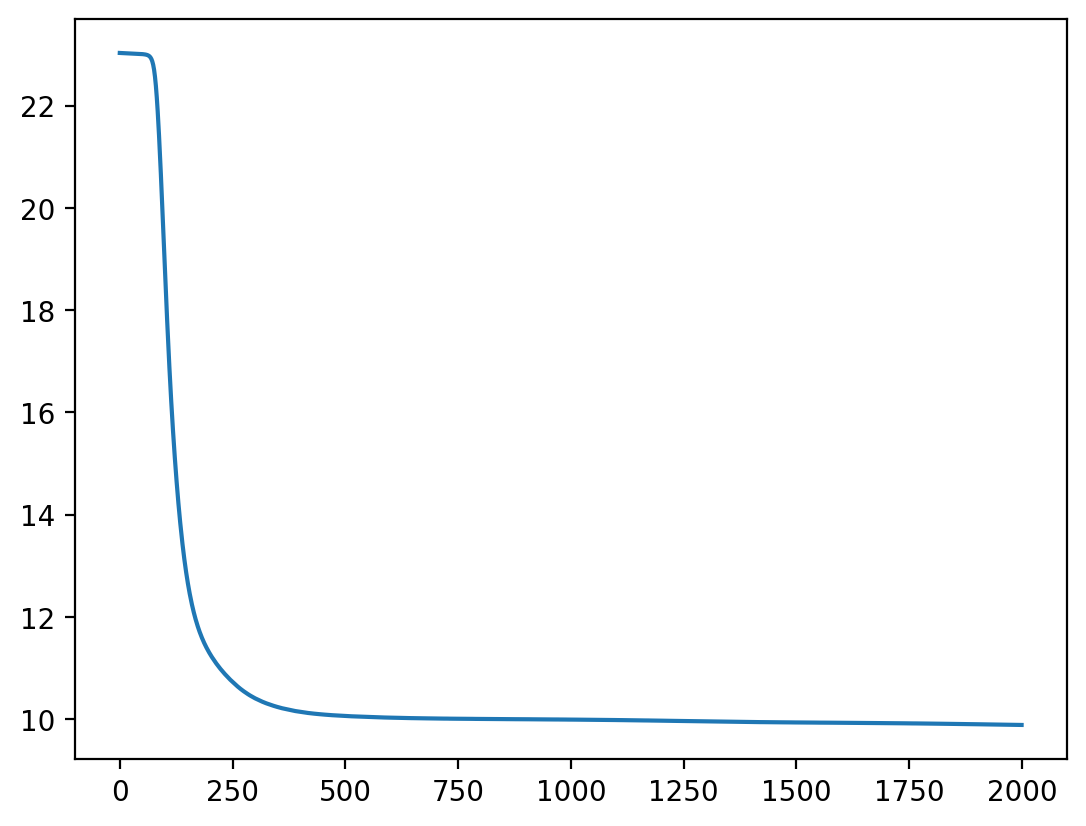

In [12]:
plt.plot(losses["train"])

In [13]:
ytest_hat = state.apply_fn(state.params, Xtest)
(ytest.argmax(axis=1) == ytest_hat.argmax(axis=1)).mean()

Array(0.6859, dtype=float32)

## Without subspace

In [14]:
class NNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500)(x)
        x = nn.elu(x)
        x = nn.Dense(300)(x)
        x = nn.elu(x)
        x = nn.Dense(300)(x)
        x = nn.elu(x)
        x = nn.Dense(300)(x)
        x = nn.elu(x)
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

In [15]:
key = jax.random.PRNGKey(314)
dim_in = 28 ** 2
Xinit = jnp.ones((1, dim_in))
model = NNet()
params_init = model.init(key, Xinit)

jax.tree_map(jnp.shape, params_init)

FrozenDict({
    params: {
        Dense_0: {
            bias: (500,),
            kernel: (784, 500),
        },
        Dense_1: {
            bias: (300,),
            kernel: (500, 300),
        },
        Dense_2: {
            bias: (300,),
            kernel: (300, 300),
        },
        Dense_3: {
            bias: (300,),
            kernel: (300, 300),
        },
        Dense_4: {
            bias: (10,),
            kernel: (300, 10),
        },
    },
})

In [16]:
%%time
key = jax.random.PRNGKey(314)


tx = optax.adam(1e-6)
state = TrainState.create(apply_fn=model.apply,
                          params=params_init,
                          tx=tx)

state, losses = sgd.train_full(
    key,
    5000,
    1000,
    state,
    X[:10_000], y[:10_000],
    lossfn,
)
losses = jax.tree_map(np.array, losses)

CPU times: user 56.5 s, sys: 7.44 s, total: 1min 3s
Wall time: 55 s


In [17]:
ytest_hat = state.apply_fn(state.params, Xtest)
(ytest.argmax(axis=1) == ytest_hat.argmax(axis=1)).mean()

Array(0.9402, dtype=float32)

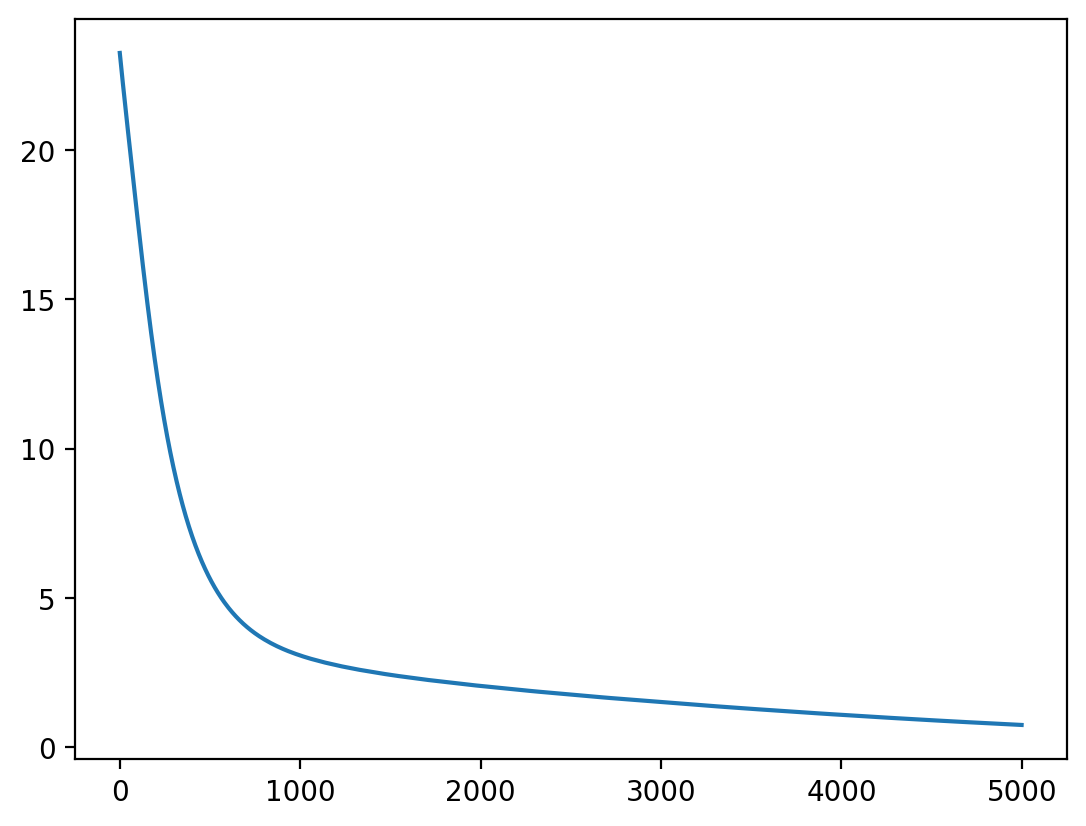

In [18]:
plt.plot(losses["train"])